In [1]:
### load needed libraries
#if(!require(irlba)) install.packages("irlba")
#if(!require(RColorBrewer)) install.packages("RColorBrewer")
#if(!require("maptools")) install.packages("maptools")
#if(!require("scatterplot3d")) install.packages("scatterplot3d")
#if(!require("umap")) install.packages("umap")
#if(!require("plotly")) install.packages("plotly")

library("irlba")
library("RColorBrewer")
library("maptools")
library("scatterplot3d")
library("minfi")
library("umap")
library("plotly")

Loading required package: Matrix

Loading required package: sp

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Please note that 'maptools' will be retired during October 2023,
plan transition at your earliest convenience (see
https://r-spatial.org/r/2023/05/15/evolution4.html and earlier blogs
for guidance);some functionality will be moved to 'sp'.
 Checking rgeos availability: FALSE

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects 

In [2]:
### import necessary variables
project_master_dir = "/stg3/data2/resource3/project/RA-TIP-CS"
version_dir = "/YesSNPqc_Female_Allchrom"

## input
analysis_object_fp = paste0(project_master_dir, "/Data/Processed_Data", "/02.gmSet_QCfiltered_All_dasen.RDS") # Female only, All Chrom, yes SNP QC filtering

# choose which loci to use
dml_output_dir = paste0(project_master_dir, "/Analysis", version_dir, "/DMLs")
selectedLoci_fp = paste0(dml_output_dir, "/dmlUnion_v2_tMem_F_cohort2_allChrom_vector.csv") # cohort 2, Memory T Cell, union

# choose which samples to use
sample_output_dir = paste0(project_master_dir, "/Analysis", version_dir, "/SampleVectors")
selectedSamples_fp = paste0(sample_output_dir, "/tMem_allD_F_cohort2_vector.csv") # cohort 2, Memory T Cell, union

## output
pca_output_dir = paste0(project_master_dir, "/Analysis", version_dir, "/PCA")
dir.create(file.path(pca_output_dir), showWarnings = FALSE)


In [3]:
# define matrix
mSet_analysis_obj = readRDS(analysis_object_fp)
beta_analysis_df = getBeta(mSet_analysis_obj)
M_analysis_df = getM(mSet_analysis_obj)

# remove rows with NAs
keepIndex = apply(M_analysis_df,1,function(x){!any(is.na(x))})
M_analysis_df = M_analysis_df[keepIndex,]
beta_analysis_df = beta_analysis_df[keepIndex,]

dim(M_analysis_df)

[1] 859442    381

In [4]:
# select only loci used in DML selection analysis, samples for this analysis
selectedLoci_vector = as.vector(read.csv(selectedLoci_fp, colClasses="character")[,1])
M_analysis_df = M_analysis_df[selectedLoci_vector,]
beta_analysis_df = beta_analysis_df[selectedLoci_vector,]

dim(M_analysis_df)

[1] 734 381

In [5]:
# select only samples for this analysis
selectedSamples_vector = as.vector(read.csv(selectedSamples_fp, colClasses="character")[,1])
M_analysis_df = M_analysis_df[,selectedSamples_vector]
beta_analysis_df = beta_analysis_df[,selectedSamples_vector]
dim(M_analysis_df)

[1] 734  84

In [6]:
### PCA
# define plot matrix
plot_mtrx = as.matrix(M_analysis_df)

# create principal components
set.seed(12)
pca1 = prcomp_irlba(plot_mtrx, n=3, center = TRUE, scale=TRUE)

a<-pca1$rotation[,1]
b<-pca1$rotation[,2]
c<-pca1$rotation[,3]

var_pc1<-paste(round(summary(pca1)[[7]][2,1],4)*100,"%",sep="")
var_pc2<-paste(round(summary(pca1)[[7]][2,2],4)*100,"%",sep="")
var_pc3<-paste(round(summary(pca1)[[7]][2,3],4)*100,"%",sep="")

xname<-paste("PC1(",var_pc1,")",sep="")
yname<-paste("PC2(",var_pc2,")",sep="")
zname<-paste("PC3(",var_pc3,")",sep="")

# define color universe
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

# create labels
id = colnames(plot_mtrx)
idSplit = strsplit(id, split = "_", fixed = T)

lab_id = sapply(idSplit, `[`, 2)
patient_id = sapply(idSplit, `[`, 1)

cell_type = as.vector(unlist(lapply(idSplit, function(x) x[length(x) -1])))
RA_status = as.vector(unlist(lapply(idSplit, function(x) x[length(x)])))


[1] "CCPneg" "CCPpos" "ERA"

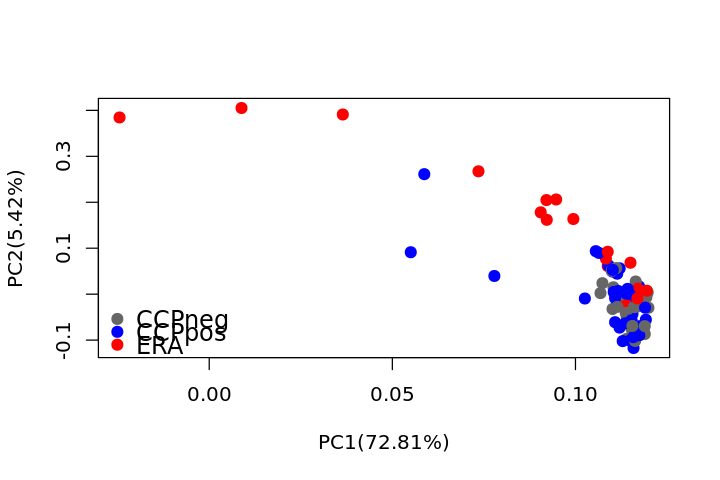

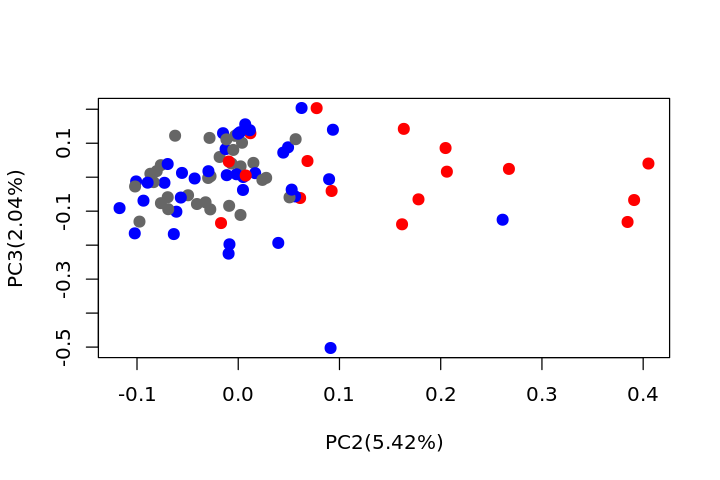

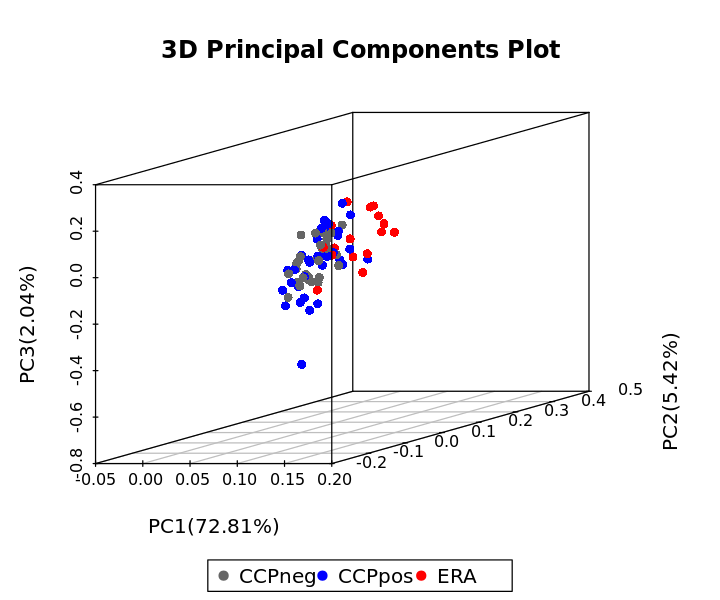

In [7]:
# Plot chart
plotColor_driver = RA_status

plotColors = c("grey40", "blue", "red")
names(plotColors) = levels(factor(plotColor_driver))
colors = unname(plotColors[plotColor_driver])

shapes = rep(19, length(plotColor_driver))

dd = as.character(id)
names(colors) = unique(dd)
names(shapes) = unique(dd)

levels(factor(plotColor_driver))

# PC1 v PC2
options(repr.plot.width=6, repr.plot.height=4)
plot(a, b, col = colors[dd], pch = shapes[dd], xlab = xname, ylab = yname, cex = 1.2)
#pointLabel(a, b, labels = plotColor_driver, cex = 1.2)
legend("bottomleft", legend = levels(factor(plotColor_driver)), col = plotColors, border = "black", bty = "n", pch = shapes, cex = 1.2)

# PC2 v PC3
options(repr.plot.width=6, repr.plot.height=4)
plot(b, c, col = colors[dd], pch = shapes[dd], xlab = yname, ylab = zname, cex = 1.2)
#pointLabel(b, c, labels = plotColor_driver, cex = 1.2)
#legend("bottomleft", legend = levels(factor(plotColor_driver)), col = plotColors, border = "black", bty = "n", pch = shapes, cex = 1.2)

# 3D version
options(repr.plot.width=6, repr.plot.height=5)
scatterplot3d(a, b, c, pch = 16, color=colors, main="3D Principal Components Plot", xlab = xname, ylab = yname, zlab = zname, angle=20)
legend("bottom", legend = levels(factor(plotColor_driver)),
       col= plotColors, 
       pch = shapes, 
       inset = -0.30, xpd = TRUE, horiz = TRUE)

In [8]:
# output to directory
setwd(pca_output_dir)
png("RA.TIP.3dPCA_raStatus_tMem_plot.png", width = 6, height = 5, res = 1200, units = "in")
scatterplot3d(a, b, c, pch = 16, color=colors, main="3D Principal Components Plot", xlab = xname, ylab = yname, zlab = zname, angle=20)
legend("bottom", legend = levels(factor(plotColor_driver)),
       col= plotColors, 
       pch = shapes, 
       inset = -0.30, xpd = TRUE, horiz = TRUE)
dev.off()

# output to directory
setwd(pca_output_dir)
pdf("RA.TIP.3dPCA_raStatus_tMem_plot.pdf", width = 6, height = 5)
scatterplot3d(a, b, c, pch = 16, color=colors, xlab = xname, ylab = yname, zlab = zname, angle=20)
dev.off()

png 
  2

png 
  2

In [9]:
# output source data
figureSourceData_df = data.frame("PC1" = a,
                                 "PC2" = b,
                                 "PC3" = c,
                                 "color" = colors)
rownames(figureSourceData_df) = names(colors)

setwd(pca_output_dir)
write.csv(figureSourceData_df,"RA.TIP.3dPCA_raStatus_tMem_data.csv", row.names=TRUE)